In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('af_backprop')
from utils import set_dropout, pdb_to_string, jnp_rmsd, save_pdb

import laxy
import sw_functions as sw
import network_functions as nf

# import libraries
from alphafold.common import protein
from alphafold.data import pipeline, templates
from alphafold.model import data, config, model
from alphafold.data import parsers

from alphafold.common import residue_constants
data_alphabet = list("ARNDCQEGHILKMFPSTWYVX-")
idx2aa = {n:a for n,a in enumerate(data_alphabet)}

In [ ]:
def get_feat(filename, alphabet="ARNDCQEGHILKMFPSTWYV"):
  '''
  Given A3M file (from hhblits)
  return MSA (aligned), MS (unaligned) and ALN (alignment)
  '''
  def parse_fasta(filename):
    '''function to parse fasta file'''    
    header, sequence = [],[]
    lines = open(filename, "r")
    for line in lines:
      line = line.rstrip()
      if len(line) == 0: pass
      else:
        if line[0] == ">":
          header.append(line[1:])
          sequence.append([])
        else:
          sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return header, sequence

  names, seqs = parse_fasta(filename)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  def get_seqref(x):
    n,seq,ref,aligned_seq = 0,[],[],[]
    for aa in list(x):
      if aa != "-":
        seq.append(a2n.get(aa.upper(),-1))
        if aa.islower(): ref.append(-1); n -= 1
        else: ref.append(n); aligned_seq.append(seq[-1])
      else: aligned_seq.append(-1)
      n += 1
    return seq, ref, aligned_seq
  
  # get the multiple sequence alignment
  max_len = 0
  ms, aln, msa = [],[],[]
  for seq in seqs:
    seq_,ref_,aligned_seq_ = get_seqref(seq)
    if len(seq_) > max_len: max_len = len(seq_)
    ms.append(seq_)
    msa.append(aligned_seq_)
    aln.append(ref_)
  
  return msa, ms, aln

In [ ]:
def get_lddt_loss(logits):
  num_bins = logits.shape[-1]
  bin_width = 1.0 / num_bins
  bin_centers = jnp.arange(start=0.5 * bin_width, stop=1.0, step=bin_width)
  probs = jax.nn.softmax(logits, axis=-1)
  predicted_lddt_ca = jnp.sum(probs * bin_centers[None, :], axis=-1)
  return 1 - predicted_lddt_ca.mean()

In [ ]:
def prep_inputs(DOM="T1064-D1"):
  a3m_file = f"casp/{DOM}.mmseqs.id90cov75.a3m"
  _, ms, aln = get_feat(a3m_file)
  a = {"ms":ms,"aln":aln}
  a_ = {"ms":[],"aln":[]}
  lens = []
  for aln_,ms_ in zip(a["aln"],a["ms"]):
    a_["ms"].append(ms_)
    a_["aln"].append(aln_)
    lens.append(len(ms_))

  lens = np.asarray(lens)
  ms = nf.one_hot(nf.pad_max(a_["ms"]))
  aln = nf.one_hot(nf.pad_max(a_["aln"]))
  N = len(ms)

  protein_obj = protein.from_pdb_string(pdb_to_string(f"casp_/{DOM}.pdb"))
  msa, mtx = parsers.parse_a3m(open(a3m_file,"r").read())
  feature_dict = {
      **pipeline.make_sequence_features(sequence=msa[0],description="none",num_res=len(msa[0])),
      **pipeline.make_msa_features(msas=[msa], deletion_matrices=[mtx])
  }
  feature_dict["residue_index"] = protein_obj.residue_index
  
  return {"lens":lens,
          "ms":ms,
          "aln":aln,
          "feature_dict":feature_dict,
          "N":N,
          "protein_obj":protein_obj}

In [ ]:
DOM = "T1070-D1"
INPUTS = prep_inputs(DOM)

In [ ]:
plt.plot(INPUTS["feature_dict"]["residue_index"])

In [ ]:
# setup which model params to use
model_name = "model_3_ptm"
model_config = config.model_config(model_name)
model_config.model.global_config.use_remat = True # checkpointing (to reduce memory usage)

model_config.model.num_recycle = 3
model_config.data.common.num_recycle = 3

model_config.data.eval.max_msa_clusters = INPUTS["N"]
model_config.data.common.max_extra_msa = 1
model_config.data.eval.masked_msa_replace_fraction = 0

# backprop through recycles
model_config.model.backprop_recycle = False
model_config.model.embeddings_and_evoformer.backprop_dgram = False

model_config = set_dropout(model_config,0)

# setup model
model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
model_runner = model.RunModel(model_config, model_params, is_training=True)

In [ ]:
# setup inputs
inputs = model_runner.process_features(INPUTS["feature_dict"], random_seed=0)

In [ ]:
def get_grad_fn(model_runner, x_ref_len, supervised=False):
  def mod(msa_params, key, inputs, model_params, msa_inputs):  

    # get embedding per sequence
    emb = nf.Conv1D_custom(msa_params["emb"])(msa_inputs["x"],key=key,scale=0.1)

    # get similarity matrix
    lengths = jnp.stack([msa_inputs["lengths"], jnp.broadcast_to(x_ref_len,msa_inputs["lengths"].shape)],-1)
    sm_mtx = emb @ emb[0,:x_ref_len].T
    sm_mask = jnp.broadcast_to(msa_inputs["x"].sum(-1,keepdims=True), sm_mtx.shape)
    sm_mtx = nf.norm_row_col(sm_mtx, sm_mask, norm_mode="fast")

    # get alignment
    aln = sw.sw()(sm_mtx, lengths, msa_params["gap"], 1.0)

    # get msa
    x_msa = jnp.einsum("nia,nij->nja", msa_inputs["x"], aln)
    
    # msa loss (push sequences to look similar to query)
    x_ref = msa_inputs["x"][0,:x_ref_len,:]
    msa_loss = 1.0 - (x_ref * x_msa.mean(0)).sum(-1).mean()

    # add gap character
    x_msa = x_msa.at[0,:,:].set(msa_inputs["x"][0,:x_ref_len,:])
    x_gap = jax.nn.relu(1 - x_msa.sum(-1,keepdims=True))
    x_msa_gap = jnp.concatenate([x_msa,jnp.zeros_like(x_gap),x_gap],-1)

    # update msa
    inputs_mod = inputs
    inputs_mod["msa_feat"] = jnp.zeros_like(inputs["msa_feat"]).at[...,0:22].set(x_msa_gap).at[...,25:47].set(x_msa_gap)

    # get alphafold ouputs
    outputs,_ = model_runner.apply(model_params, key, inputs_mod)
    
    #################
    # compute loss
    #################
    
    # confidence metrics
    pae_loss = jax.nn.softmax(outputs["predicted_aligned_error"]["logits"])
    pae_loss = (pae_loss * jnp.arange(pae_loss.shape[-1])).sum(-1).mean()
    plddt_loss = jax.nn.softmax(outputs["predicted_lddt"]["logits"])
    plddt_loss = (plddt_loss * jnp.arange(plddt_loss.shape[-1])[::-1]).sum(-1).mean()
    
    # distance to correct solution
    rmsd_loss = jnp_rmsd(INPUTS["protein_obj"].atom_positions[:,1,:],
                         outputs["structure_module"]["final_atom_positions"][:,1,:])

    if supervised:
      loss = rmsd_loss
    else:
      loss = pae_loss + plddt_loss + msa_loss
      
    plddt = 1 - get_lddt_loss(outputs["predicted_lddt"]["logits"])    
    outs = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
            "final_atom_mask":outputs["structure_module"]["final_atom_mask"]}

    return loss, ({"plddt": plddt,
                   "rmsd":rmsd_loss, "msa_loss":msa_loss,
                   "outputs":outs,                   
                   "msa":x_msa, "seq":x_msa[0],
                  })
  
  return mod, jax.value_and_grad(mod, has_aux=True, argnums=0)

In [ ]:
######################
# SETUP ADAM
######################

# gradient function
msa_inputs = {"x":INPUTS["ms"], "aln":INPUTS["aln"], "lengths":INPUTS["lens"]}
loss_fn, grad_fn = get_grad_fn(model_runner, x_ref_len=INPUTS["lens"][0])

from jax.experimental.optimizers import adam
init_fun, update_fun, get_params = adam(step_size=1e-2)

@jax.jit
def step(i, state, key, inputs, model_params, msa_inputs):
  (loss, outs), grad = grad_fn(get_params(state), key, inputs, model_params, msa_inputs)
  state = update_fun(i, grad, state)
  return state, (loss,outs)

In [ ]:
LOSSES = []
for mode in ["random","ba","ba_sup","smurf","ba_smurf","ba_sup_smurf"]: # testing 6 MSA pretraining methods
  # random = starting with random convolutions
  # ba = pretrain convolutions using basic-align
  # ba_sup = pretrain convolutions using basic-align to recreate the initial MSA
  # smurf = pretrain convolutions using smurf
  # ba_smurf = pretrain convolutions using smurf+basic-align
  # ba_sup_smurf = pretrain convolutions using smurf+basic-align

  BEST_PLDDT = 0
  losses = []
  for seed in range(5): # note: in manuscript we ran 20 each
    key = jax.random.PRNGKey(seed)
    ###################################
    # pretrain w/ BasicAlign
    ###################################
    msa_inputs = {"x":INPUTS["ms"], "aln":INPUTS["aln"], "lengths":INPUTS["lens"]}
    if mode == "random":
      state = init_fun({"emb":nf.Conv1D_custom()(20,512,18,key=key),
                        "gap":jnp.full([],-3.0,dtype=jnp.float32)})
    if "ba" in mode:
      if "sup" in mode:
        msa_model = nf.BasicAlign(X=INPUTS["ms"],lengths=INPUTS["lens"],
                                  sw_open=None, sw_gap=-3.0, sw_learn_gap=True,
                                  seed=seed, batch_size=INPUTS["N"],
                                  supervise=True, nat_aln=INPUTS["aln"])
      else:
        msa_model = nf.BasicAlign(X=INPUTS["ms"],lengths=INPUTS["lens"],
                                  sw_open=None, sw_gap=-3.0, sw_learn_gap=True,
                                  seed=seed, batch_size=INPUTS["N"])
    if "smurf" in mode:
      smurf_model = nf.MRF(X=INPUTS["ms"], lengths=INPUTS["lens"], batch_size=INPUTS["N"],
                           sw_open=None, sw_gap=-3.0, sw_learn_gap=True, seed=seed)
      if "ba" in mode:
        _ = msa_model.fit(2000, verbose=False)
        msa_params = msa_model.opt.get_params()

        smurf_params = smrf_model.opt.get_params()
        smurf_params.update({k:msa_params[k] for k in ["emb","gap","open"]})
        smurf_model.opt.set_params(smurf_params)
        
      _ = smurf_model.fit(2000, verbose=False)
      smurf_params = smurf_model.opt.get_params()
      state = init_fun({"emb":smurf_params["emb"],"gap":smurf_params["gap"]})    
    
    elif "ba" in mode:
      _ = msa_model.fit(4000, verbose=False)
      msa_params = msa_model.opt.get_params()
      state = init_fun({"emb":msa_params["emb"],"gap":msa_params["gap"]})    
        
    # optimize!
    losses.append([])
    for i in range(300):
      key,subkey = jax.random.split(key)
      state,(loss,outs) = step(i, state, subkey, inputs, model_params, msa_inputs)
      
      # save results
      losses[-1].append([float(loss),*[float(outs[x]) for x in ["plddt","rmsd","msa_loss"]]])
      print(seed, i, *losses[-1][-1])
      if outs["plddt"] > BEST_PLDDT:
        BEST_PLDDT = outs["plddt"]
        save_pdb(outs,f"{DOM}.REDO3.{mode}.seed{seed}.pred.pdb")
        
  LOSSES.append(losses)  
  
np.save(f"{DOM}.traj.REDO3.npy",LOSSES)

In [ ]:
LOSSES = np.load(f"{DOM}.traj.REDO3.npy")

In [ ]:
DOMS = ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"]
VALS = [[0.627021797996172,7.9085627],[0.522569996053579,9.804814],
        [0.725891903100609,8.154645],[0.361457601819099,17.92791],
        [0.354278629507625,13.859991]]
vals = {d:v for d,v in zip(DOMS,VALS)}

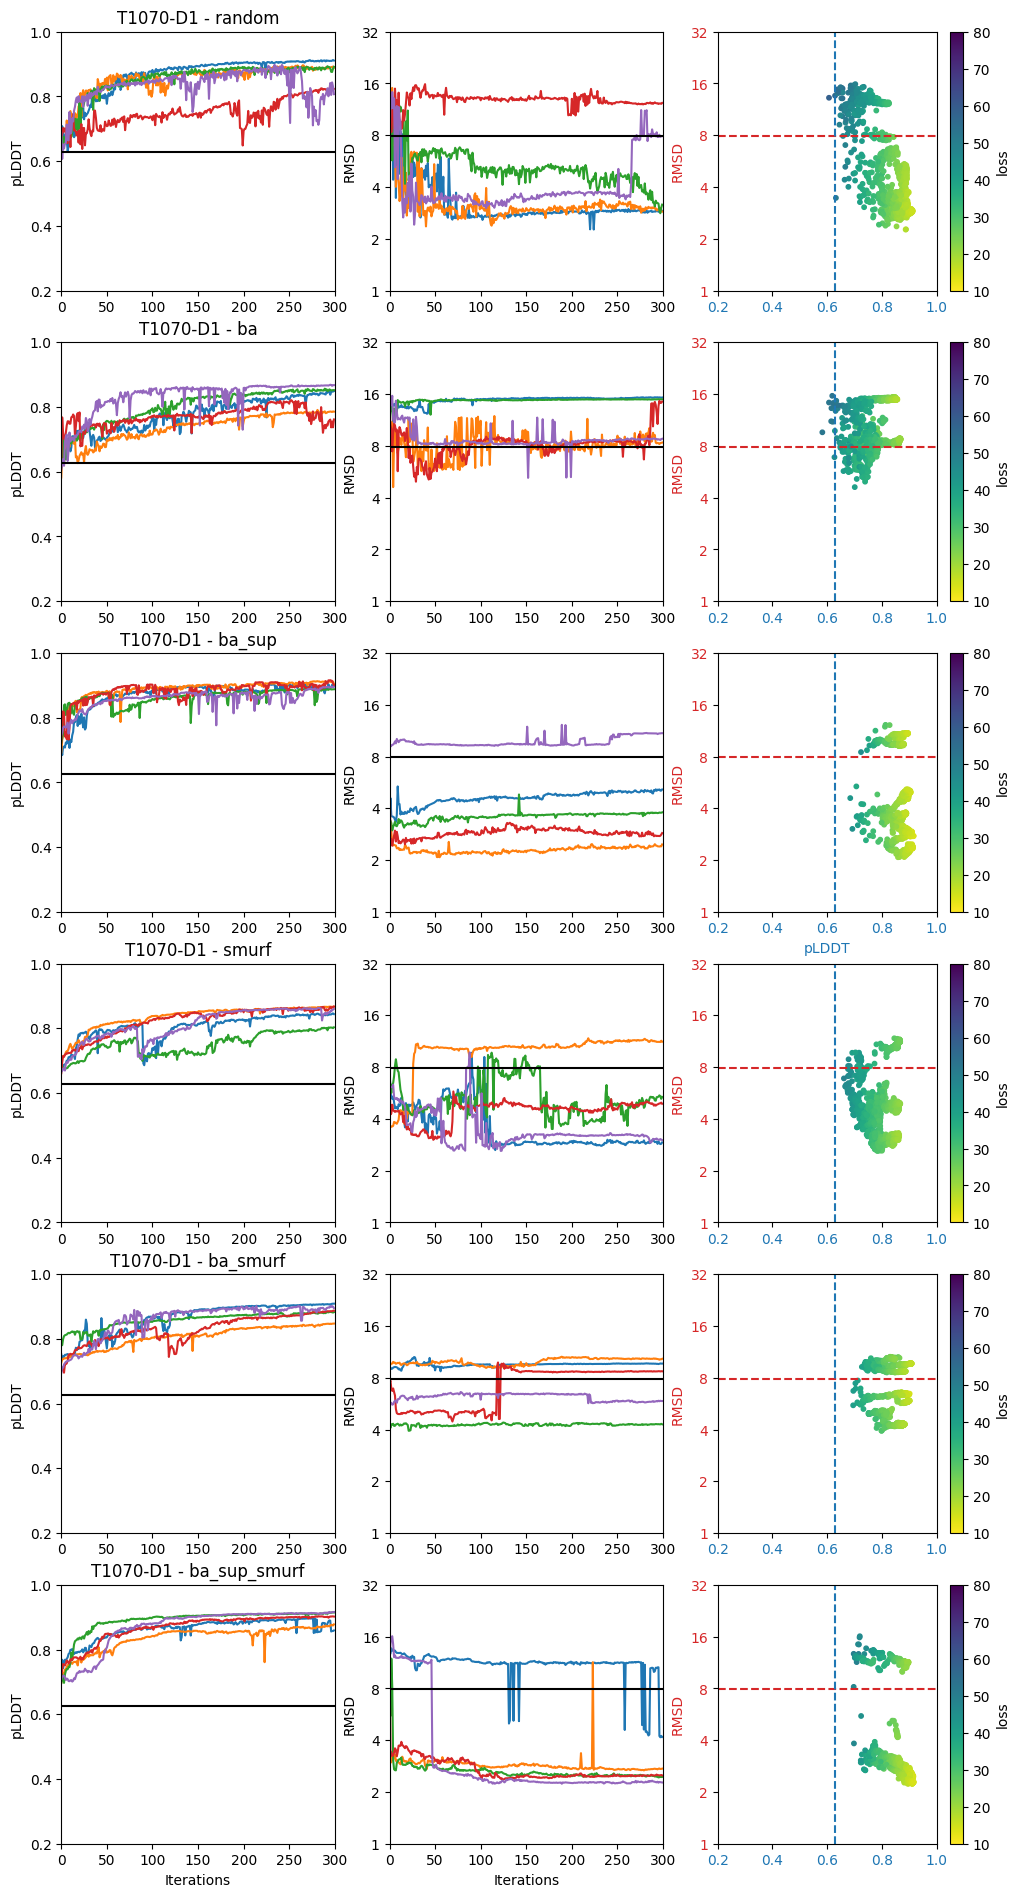

In [123]:
plt.figure(figsize=(12,4*6),dpi=100)

k = 1
for losses,nam in zip(LOSSES,["random", "ba", "ba_sup", "smurf", "ba_smurf", "ba_sup_smurf"]):
  losses = np.asarray(losses)
  
  plt.subplot(6,3,k)
  plt.title(f"{DOM} - {nam}")
  
    
  plt.plot(losses[:,:,1].T)
  if k in [7+9]: plt.xlabel("Iterations");
  if k in [1,4,7,1+9,4+9,7+9]: plt.ylabel("pLDDT")
  plt.ylim(0.2,1.0)
  plt.xlim(0,300)
  plt.yticks([0.2,0.4,0.6,0.8,1.0],[0.2,0.4,0.6,0.8,1.0])
  plt.plot([0,300],[vals[DOM][0],vals[DOM][0]],color="black")
  k += 1
  
  plt.subplot(6,3,k)
  plt.plot(losses[:,:,2].T)
  if k in [8+9]: plt.xlabel("Iterations")
  plt.ylabel("RMSD")
  plt.ylim(1,32)
  plt.xlim(0,300)
  plt.yscale("log",basey=2);plt.yticks([1,2,4,8,16,32],[1,2,4,8,16,32])
  plt.plot([0,300],[vals[DOM][1],vals[DOM][1]],color="black")
  k += 1
  
  plt.subplot(6,3,k)
  plt.scatter(losses[:,:,1],
              losses[:,:,2],
              c=losses[:,:,0],vmin=10,vmax=80,s=10, cmap="viridis_r")
  
  plt.yscale("log",basey=2,)
  plt.yticks([1,2,4,8,16,32],[1,2,4,8,16,32],color="tab:red")
  plt.ylim(1,32)
  plt.ylabel("RMSD",color="tab:red")

  if k in [9]: plt.xlabel("pLDDT",color="tab:blue")
  plt.xlim(0.2,1.0)
  plt.xticks([0.2,0.4,0.6,0.8,1.0],[0.2,0.4,0.6,0.8,1.0],color="tab:blue")

  plt.plot([0.2,1],[vals[DOM][1],vals[DOM][1]],"--",color="tab:red")
  plt.plot([vals[DOM][0],vals[DOM][0]],[1,32],"--",color="tab:blue")

  plt.colorbar(label="loss")
  k += 1
  
#plt.savefig(f"{DOM}.traj.REDO3.pdf",bbox_inches='tight')
plt.show()

In [124]:
LOSSES_FLAT = np.concatenate(LOSSES,0)
best_idx = LOSSES_FLAT[:,-1,1].argmax()

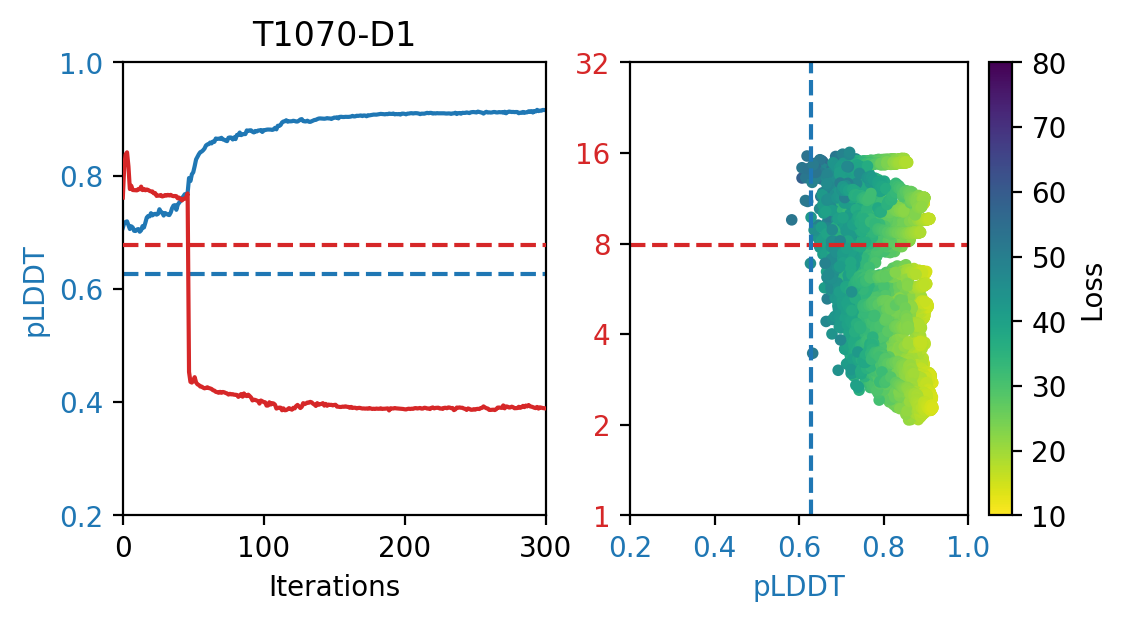

In [125]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),dpi=200)

ax1.set_title(f"{DOM}")

ax1.plot(LOSSES_FLAT[best_idx][:,1],color="tab:blue")
ax1.set_ylabel("pLDDT",color="tab:blue")
ax1.set_ylim(0.2,1.0)
ax1.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.2,0.4,0.6,0.8,1.0],color="tab:blue")
ax1.set_xlim(0,300)
ax1.set_xlabel("Iterations")
ax1.plot([0,300],[vals[DOM][0],vals[DOM][0]],"--",color="tab:blue")


ax1_ = ax1.twinx()
ax1_.plot(LOSSES_FLAT[best_idx][:,2],color="tab:red")
ax1_.plot([0,300],[vals[DOM][1],vals[DOM][1]],"--",color="tab:red")
ax1_.axis("off")

ax2.get_shared_y_axes().join(ax2, ax1_)
s = ax2.scatter(LOSSES_FLAT[...,1],
                LOSSES_FLAT[...,2],
                c=LOSSES_FLAT[...,0],vmin=10,vmax=80,s=10, cmap="viridis_r")

fig.colorbar(s, ax=ax2, label="Loss")

ax2.set_yscale("log",basey=2,)
ax2.set_yticks([1,2,4,8,16,32])
ax2.set_yticklabels([1,2,4,8,16,32],color="tab:red")
ax2.set_ylim(1,32)
#ax2.set_ylabel("RMSD",color="tab:red")

ax2.set_xlabel("pLDDT",color="tab:blue")
ax2.set_xlim(0.2,1.0)
ax2.set_xticks([0.2,0.4,0.6,0.8,1.0])
ax2.set_xticklabels([0.2,0.4,0.6,0.8,1.0],color="tab:blue")

ax2.plot([0.2,1],[vals[DOM][1],vals[DOM][1]],"--",color="tab:red")
ax2.plot([vals[DOM][0],vals[DOM][0]],[1,32],"--",color="tab:blue")

#fig.savefig(f"{DOM}.traj.REDO3.best.pdf",bbox_inches='tight')
plt.show()